In [1]:
import numpy as np
import numpy.fft as fft
from astropy.io import fits
import matplotlib.pyplot as plt
import galsim
from IPython import display
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
img1 = np.abs(fits.open('psf2asec-96.psf.fits')[0].data[0,0,:,:])
print(img1.shape)

(96, 96)


### PSF

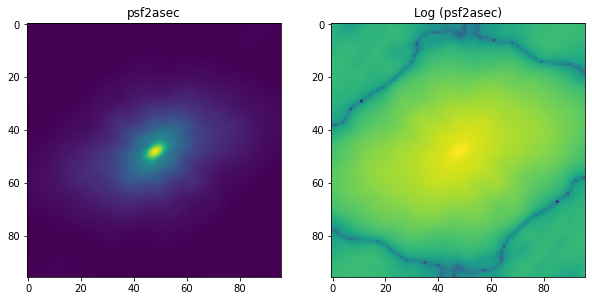

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(img1); ax1.set_title('psf2asec');
ax2.imshow(np.log10(img1)); ax2.set_title('Log (psf2asec)');

# Convolution of a Gaussian Galaxy & PSF using Galsim functions

In [4]:
gal_flux = 1.e5    # total counts on the image
gal_sigma = 2.     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 30.        # standard deviation of the counts in each pixel

In [5]:
gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma)
psf = galsim.Gaussian(flux=1., sigma=2.)

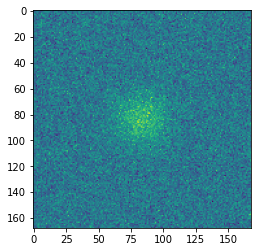

In [6]:
final = galsim.Convolve([gal, psf])
image = final.drawImage(scale=pixel_scale)
image.addNoise(galsim.GaussianNoise(sigma=noise))

plt.imshow(image.array)
plt.show()

# Convolution of the given PSF with a Gaussian Galsim Object (multiplication in Fourier Space)

In [7]:
gal_1 = np.abs(galsim.Gaussian(flux=gal_flux, sigma=gal_sigma).drawImage(nx=96, ny=96).array)
psf_img1 = galsim.Image(img1, copy=True).array

gal_1 /= np.sum(gal_1)
psf_img1 /= np.sum(psf_img1)

Dimensions - (96, 96) (96, 96)


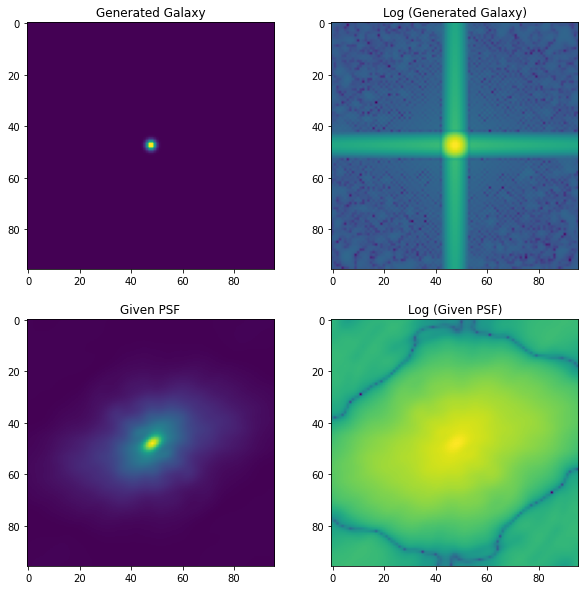

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.imshow(gal_1); ax1.set_title('Generated Galaxy');
ax2.imshow(np.log10(gal_1)); ax2.set_title('Log (Generated Galaxy)');
ax3.imshow(psf_img1); ax3.set_title('Given PSF');
ax4.imshow(np.log10(psf_img1)); ax4.set_title('Log (Given PSF)');

m = gal_1.shape
n = psf_img1.shape
print('Dimensions -', m,n) 

### FFT + Gaussian Noise

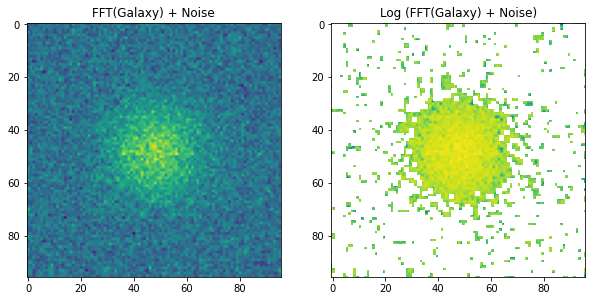

In [9]:
gal_1_fft = np.pad(np.abs(fft.fftshift(fft.fft2(gal_1))), (abs(m[0]-n[0])//2, abs(m[1]-n[1])//2 ), 'constant')     
psf_img1_fft = np.abs(fft.fftshift(fft.fft2(psf_img1)))     

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 1.0e2                                            # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_1_fft)/SNR            # Standard deviation of noise

gal_1_fft_GSO = galsim.Image(gal_1_fft, copy=True)       # Stored as GSO
gal_1_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(gal_1_fft_GSO.array); ax1.set_title('FFT(Galaxy) + Noise');
ax2.imshow(np.log10(gal_1_fft_GSO.array)); ax2.set_title('Log (FFT(Galaxy) + Noise)');

### Convolve with PSF

(1.0, 1.0)

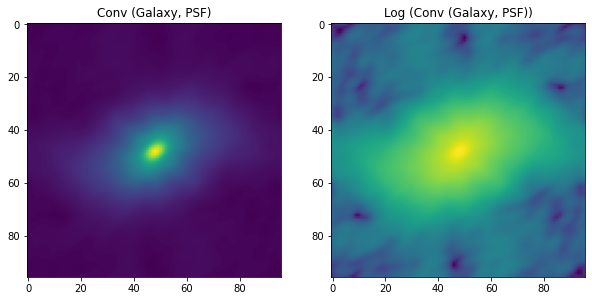

In [10]:
conv1 = np.multiply(gal_1_fft_GSO.array, psf_img1_fft)

final_gal = np.abs(fft.ifftshift(fft.ifft2(conv1)))                 # IFFT to get back to brightness domain
final_gal *= (np.sum(gal_1)/np.sum(final_gal))                      # Normalisation

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(final_gal); ax1.set_title('Conv (Galaxy, PSF)');
ax2.imshow(np.log10(final_gal)); ax2.set_title('Log (Conv (Galaxy, PSF))');

np.sum(gal_1), np.sum(final_gal)

# Gradient Descent

In [11]:
iters = 7500

# Original Implementation - https://waller-lab.github.io/DiffuserCam/tutorial/GD.html

def initMatrices(h):
    pixel_start = (np.max(h) + np.min(h))/2
    x = np.ones(h.shape)*pixel_start

    init_shape = h.shape
    padded_shape = [nextPow2(2*n - 1) for n in init_shape]
    starti = (padded_shape[0]- init_shape[0])//2
    endi = starti + init_shape[0]
    startj = (padded_shape[1]//2) - (init_shape[1]//2)
    endj = startj + init_shape[1]
    hpad = np.zeros(padded_shape)
    hpad[starti:endi, startj:endj] = h

    H = fft.fft2(fft.ifftshift(hpad), norm="ortho")
    Hadj = np.conj(H)

    def crop(X):
        return X[starti:endi, startj:endj]

    def pad(v):
        vpad = np.zeros(padded_shape).astype(np.complex64)
        vpad[starti:endi, startj:endj] = v
        return vpad

    utils = [crop, pad]
    v = np.real(pad(x))
    
    return H, Hadj, v, utils


def nextPow2(n):
    return int(2**np.ceil(np.log2(n)))


def grad(Hadj, H, vk, b, crop, pad):
    Av = calcA(H, vk, crop)
    diff = Av - b
    return np.real(calcAHerm(Hadj, diff, pad))


def calcA(H, vk, crop):
    Vk = fft.fft2(fft.ifftshift(vk))
    return crop(fft.fftshift(fft.ifft2(H*Vk)))


def calcAHerm(Hadj, diff, pad):
    xpad = pad(diff)
    X = fft.fft2(fft.ifftshift(xpad))
    return fft.fftshift(fft.ifft2(Hadj*X))


def nmse(signal_1, singal_2):
    return (np.linalg.norm(singal_2 - signal_1) ** 2 /
            np.linalg.norm(signal_1) ** 2)

In [12]:
def grad_descent(h, b):
    H, Hadj, v, utils = initMatrices(h)
    crop = utils[0]
    pad = utils[1]
    
    x_opt = np.zeros(v.shape)
    count = 0
    
    nmse_arr = np.zeros((iters))
        
    alpha = np.real(1.8/(np.max(Hadj * H)))
    iterations = 0
     
    def non_neg(xi):
        xi = np.maximum(xi,0)
        return xi
    
    #proj = lambda x:x  # Do no projection
    proj = non_neg      # Enforce nonnegativity at every gradient step


    parent_var = [H, Hadj, b, crop, pad, alpha, proj]
    
    vk = v     
    
    # FISTA update parameters
    tk = 1
    xk = v
    
        
    for i in range(iters):     
        
        # FISTA update
        vk, tk, xk = fista_update(vk, tk, xk, parent_var)

        image = proj(crop(vk))
        image /= np.sum(image)
        
        nmse_arr[i] = nmse(gal_1, image)
        
        if (i!=0) and (nmse_arr[i]<nmse_arr[i-1]) and count==0:
            x_opt = image
        elif (i!=0) and (nmse_arr[i]>nmse_arr[i-1]):
            count += 1
        
        if i % 100 == 0 and i!=0:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,16))
            ax1.imshow(image); ax1.set_title('Reconstruction after iteration {}'.format(i));
            ax2.imshow(np.log10(image)); ax2.set_title('Log Intensity Scale');
         
            ax3.plot(image[48,:], label='image');
            ax3.plot(gal_1[48,:], label='gal_1'); 
            leg = ax3.legend()
            ax3.set_aspect(1.0/ax3.get_data_ratio()); ax3.set_title('Intensity Plot (Central Slice)')
            
            display.display(fig)
            display.clear_output(wait=True) 
        
    return image, x_opt, nmse_arr

### FISTA Update

In [13]:
def fista_update(vk, tk, xk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    x_k1 = xk
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    xk = proj(vk)
    t_k1 = (1+np.sqrt(1+4*tk**2))/2
    vk = xk+(tk-1)/t_k1*(xk - x_k1)
    tk = t_k1
    
    return vk, tk, xk

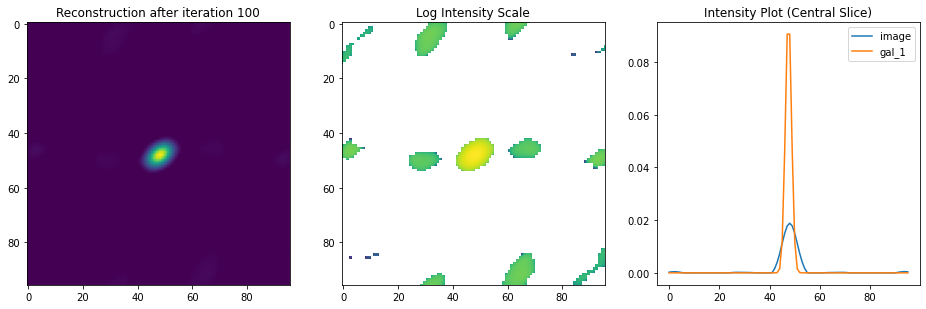

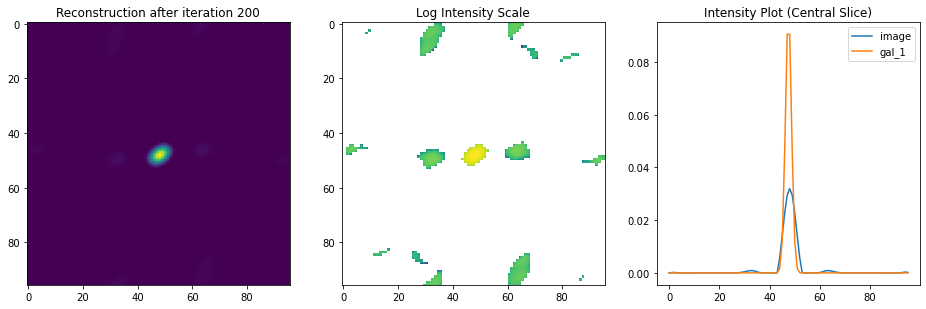

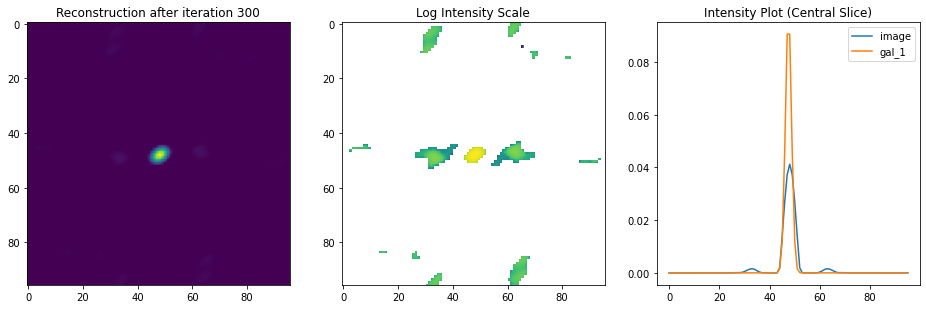

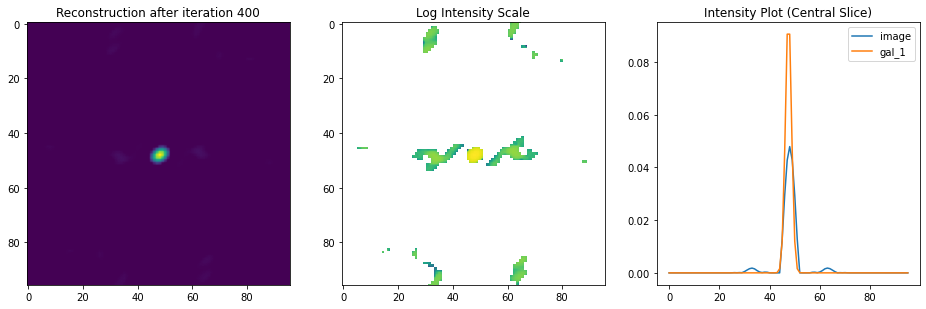

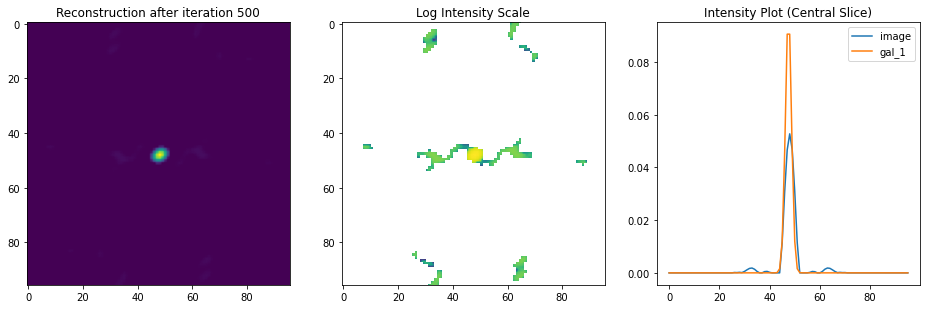

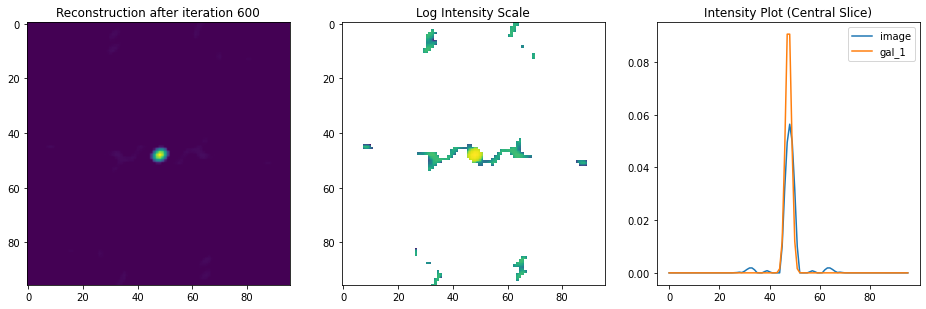

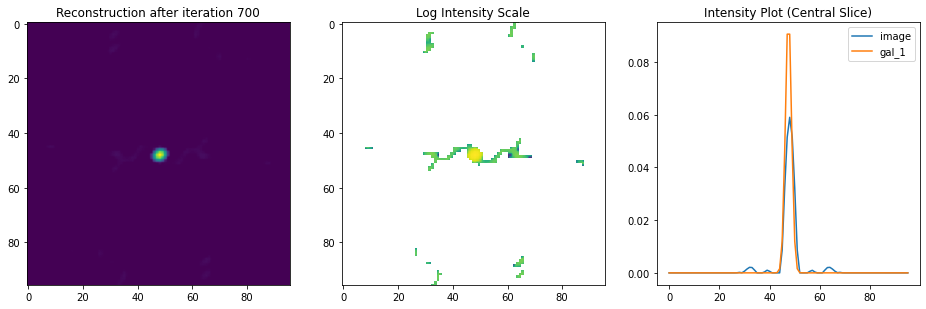

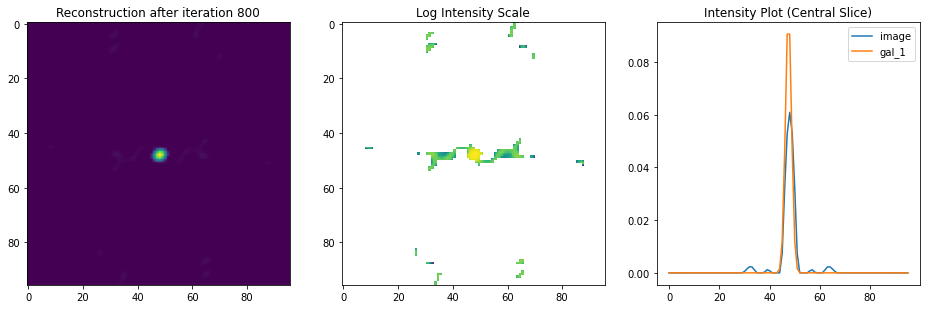

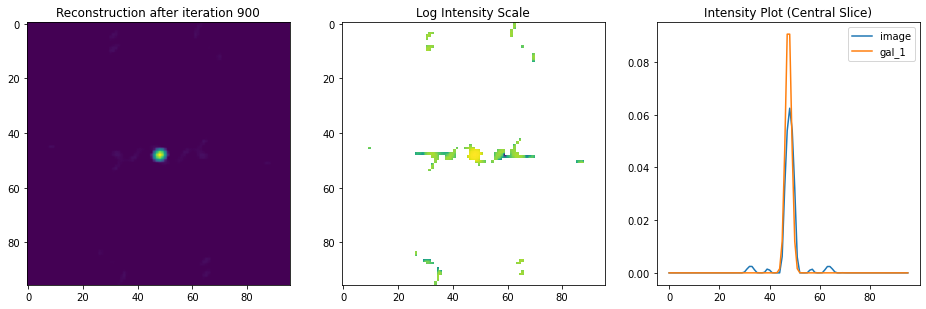

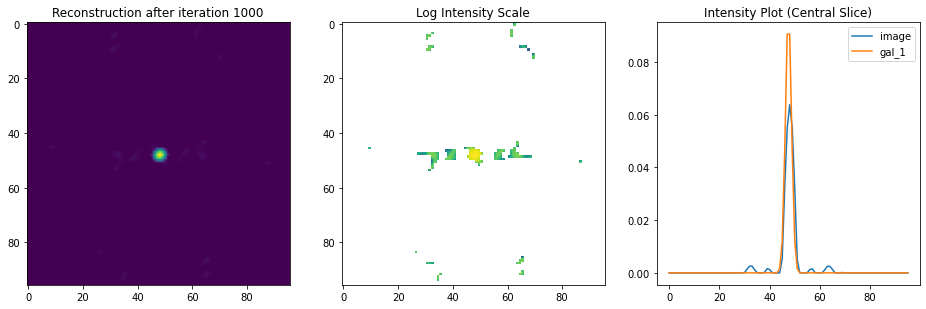

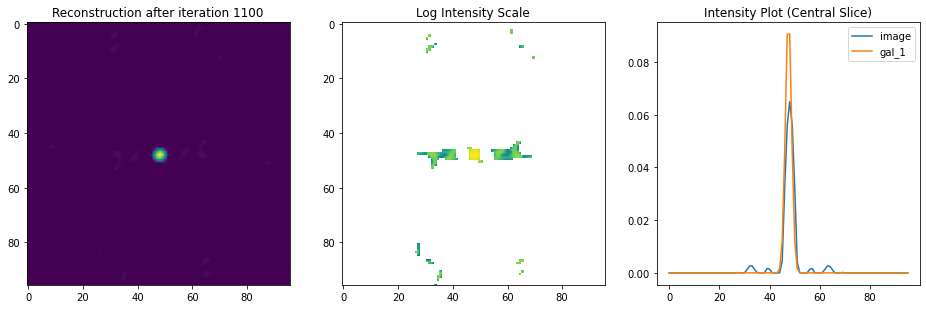

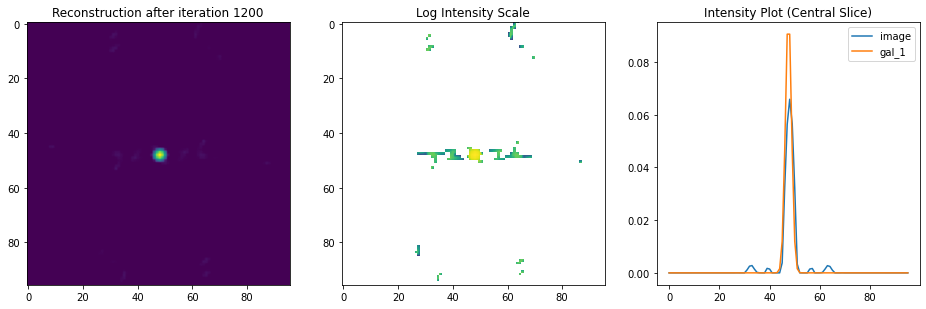

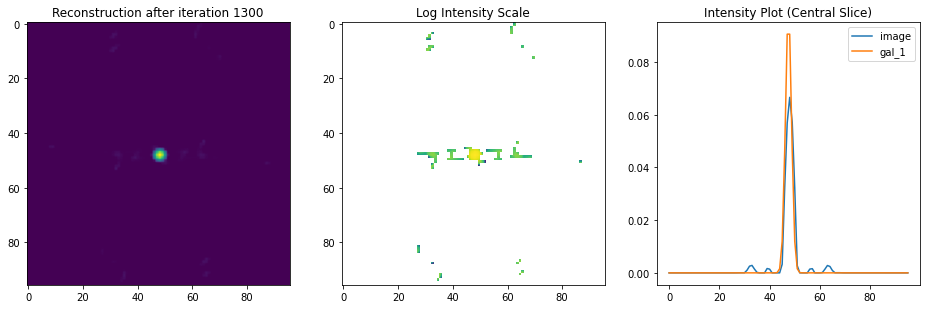

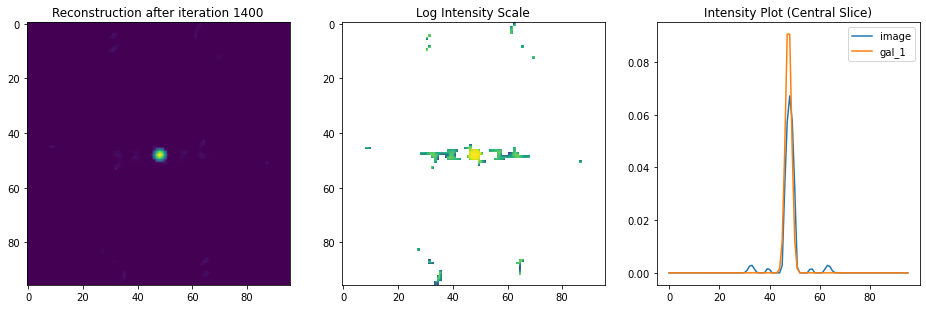

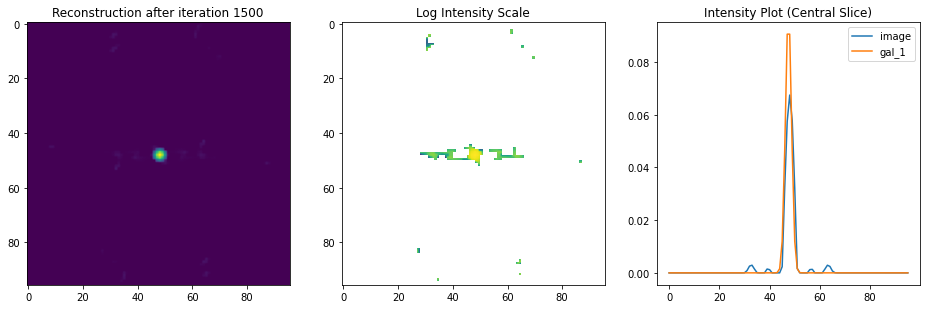

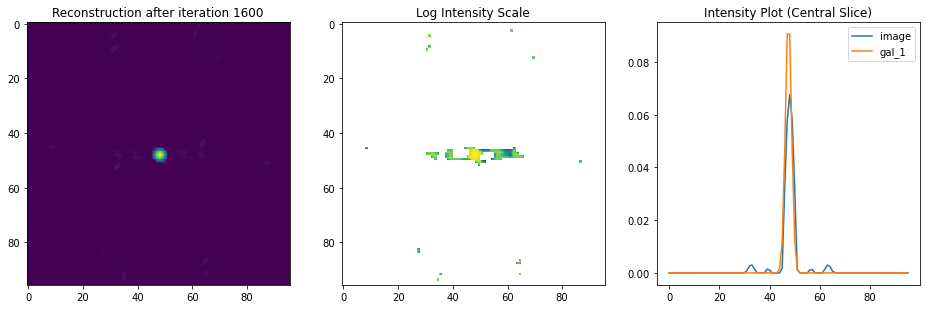

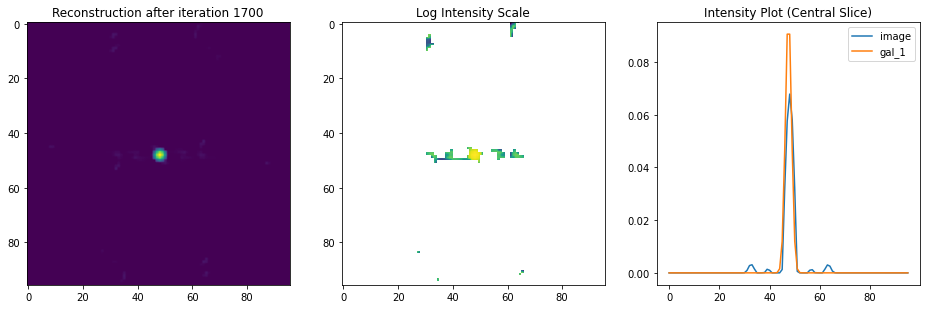

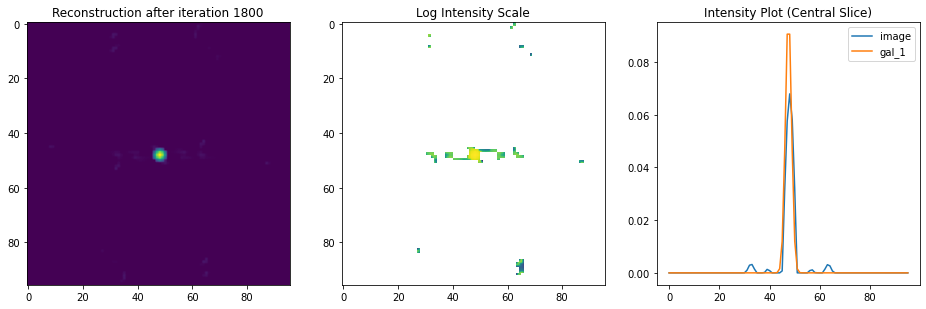

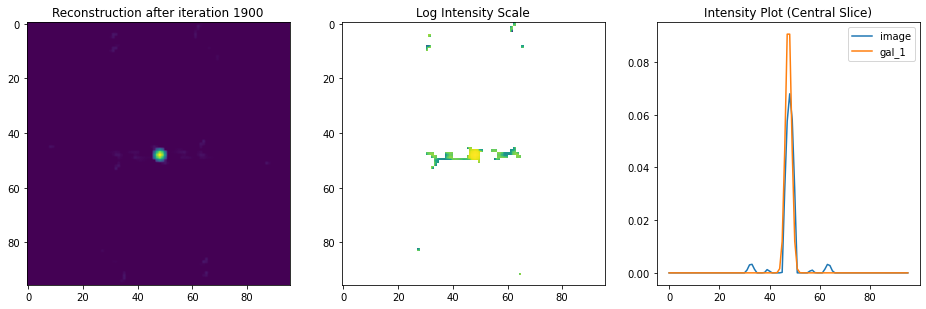

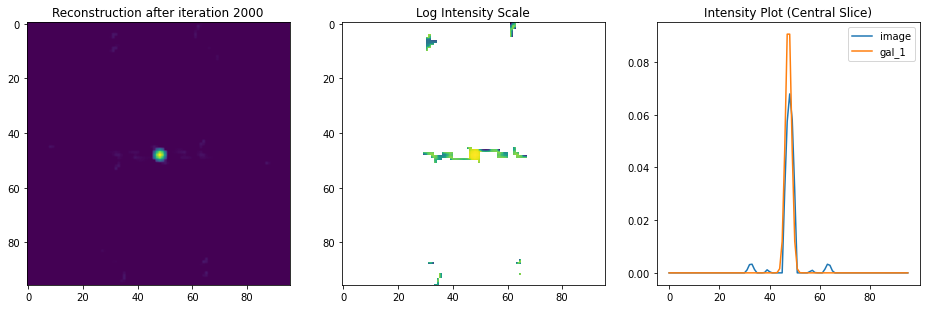

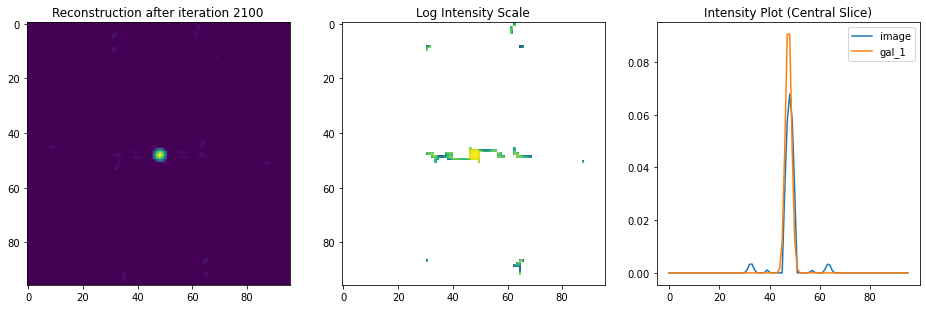

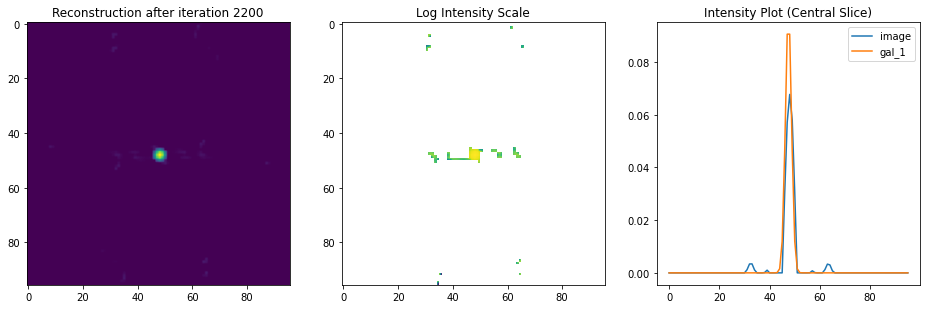

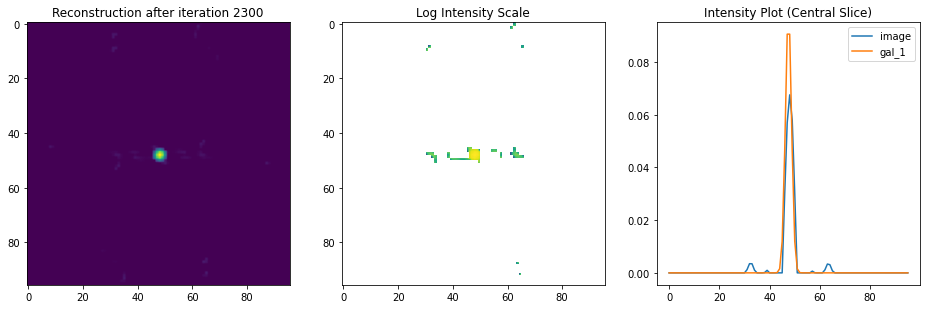

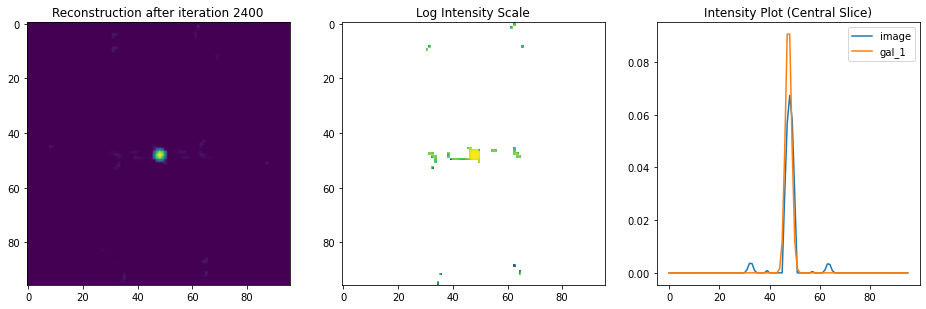

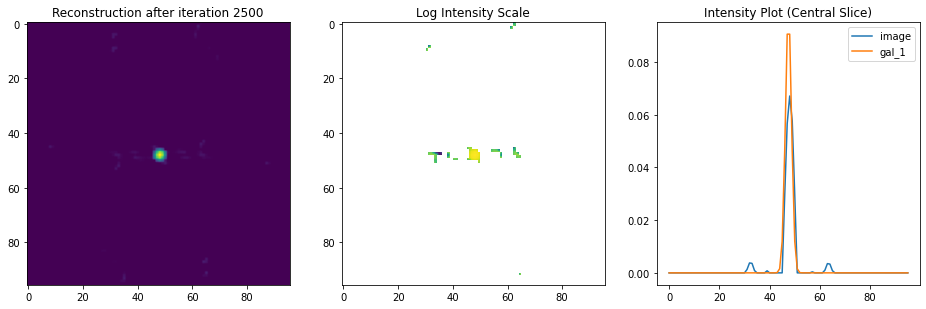

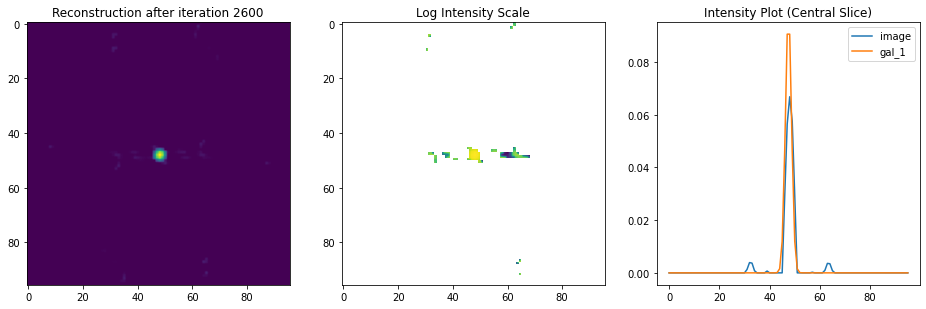

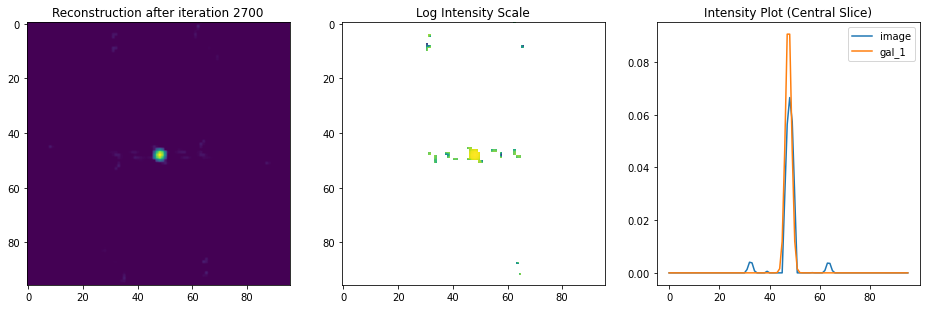

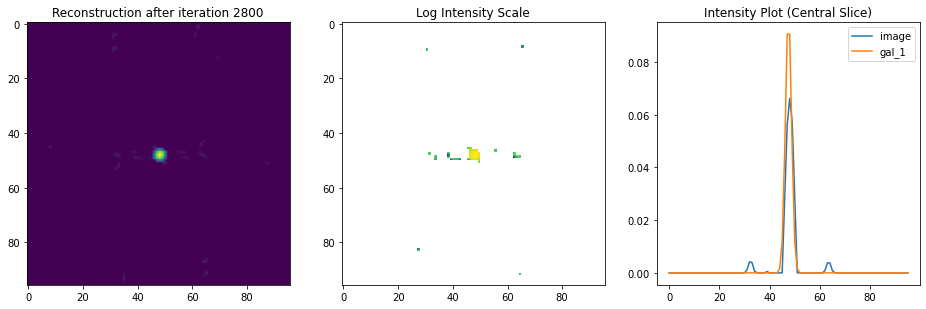

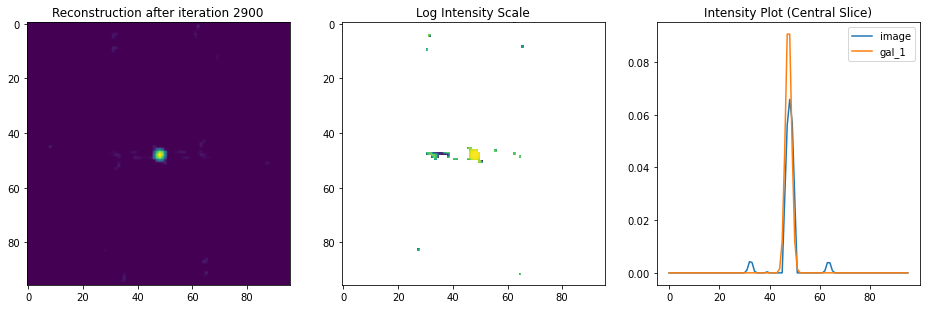

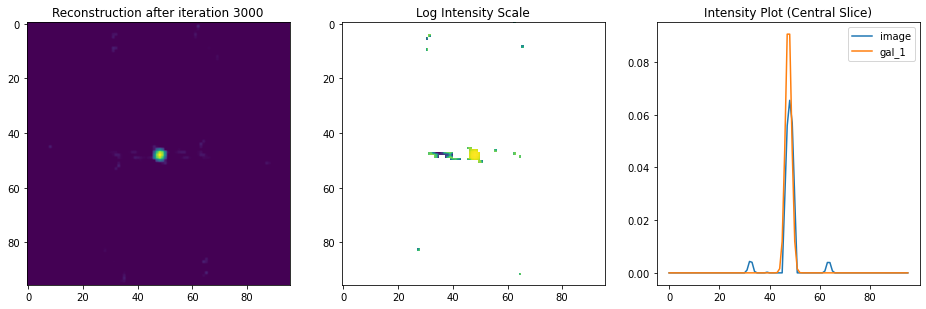

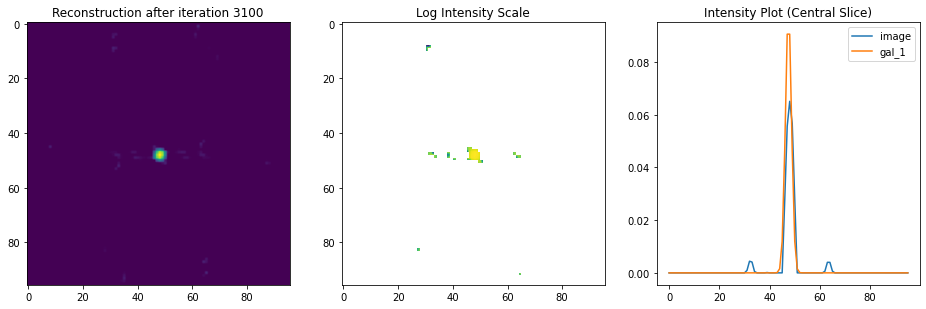

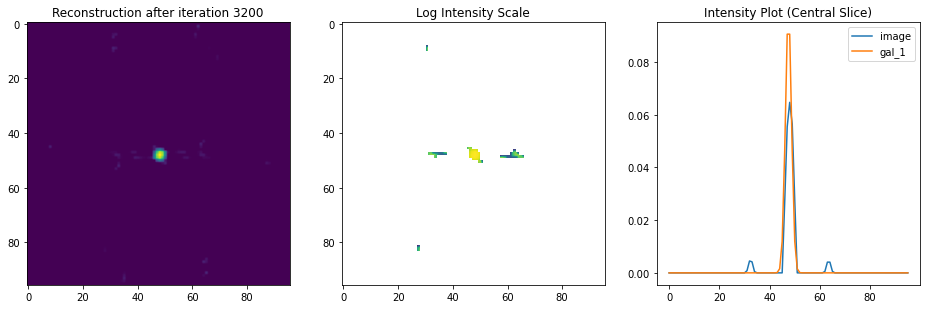

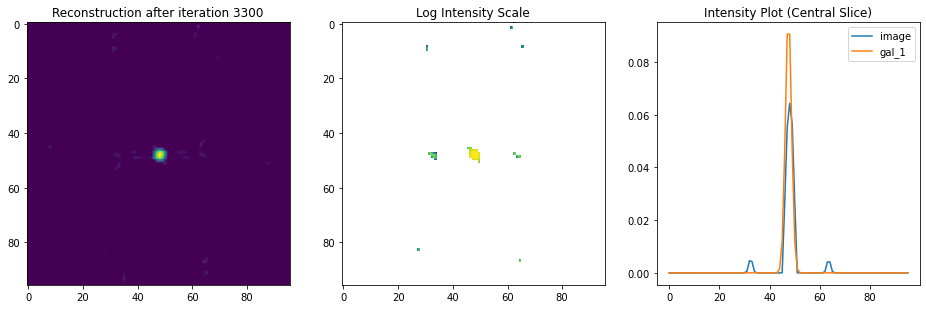

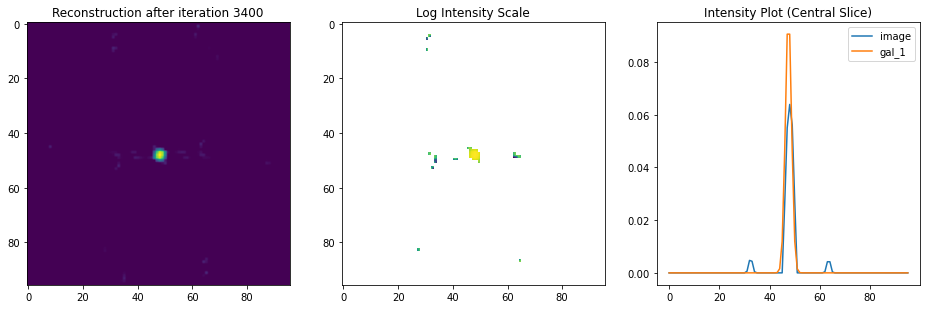

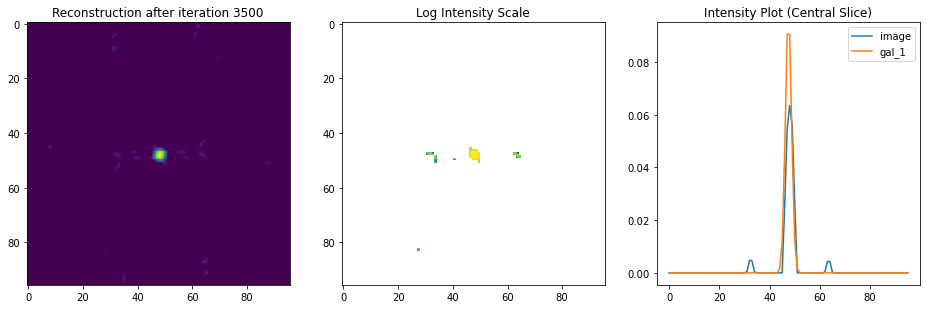

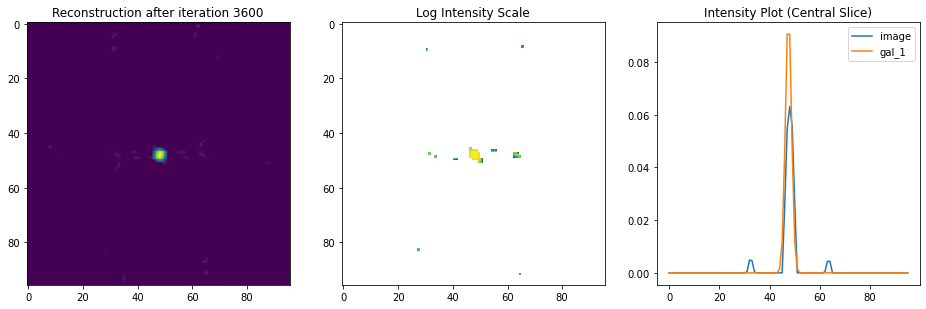

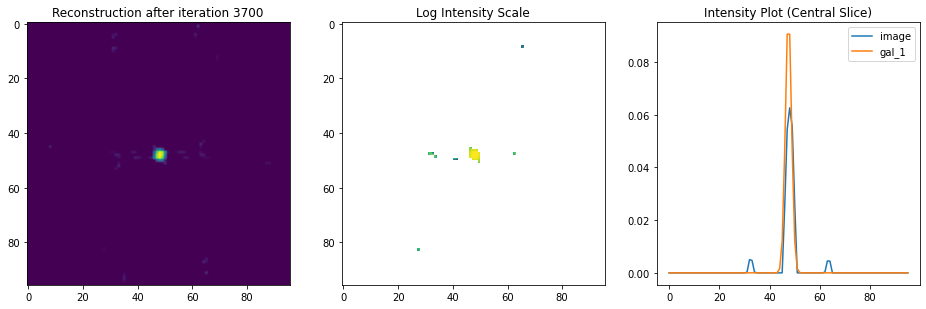

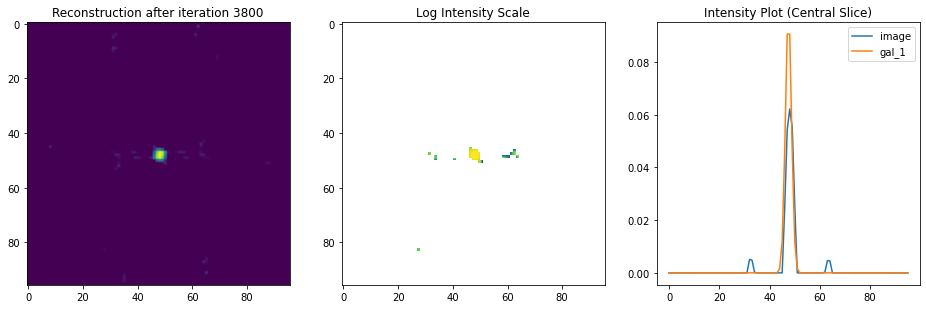

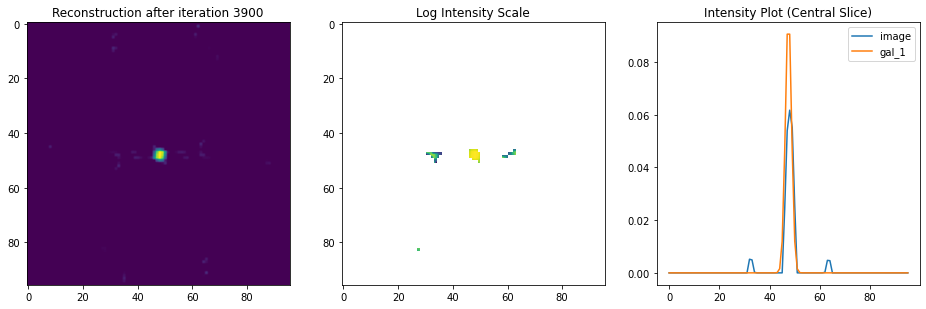

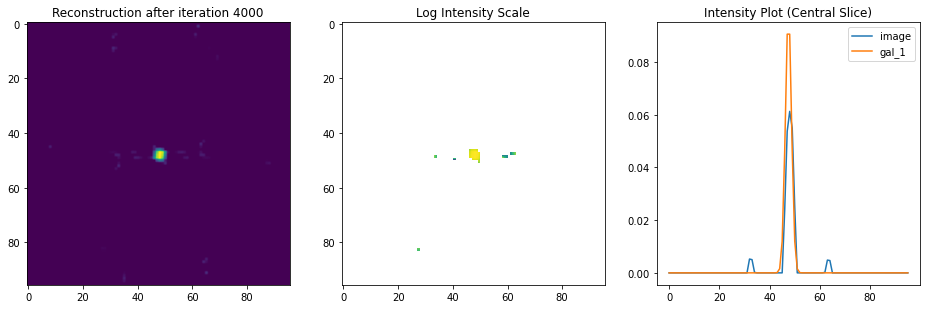

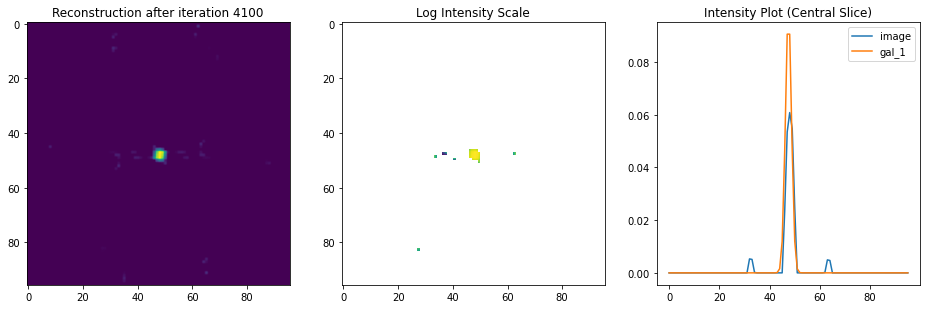

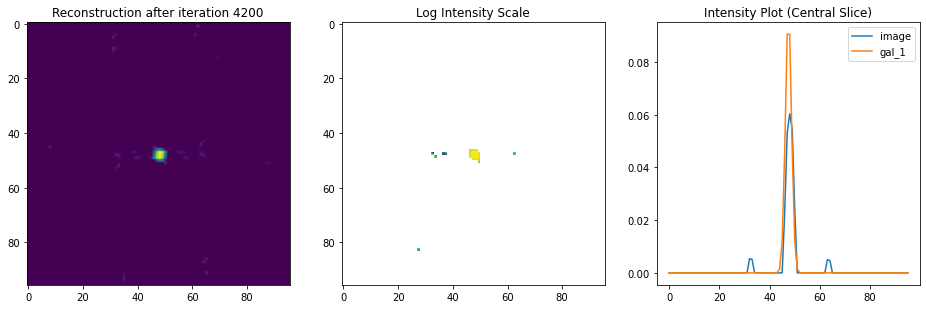

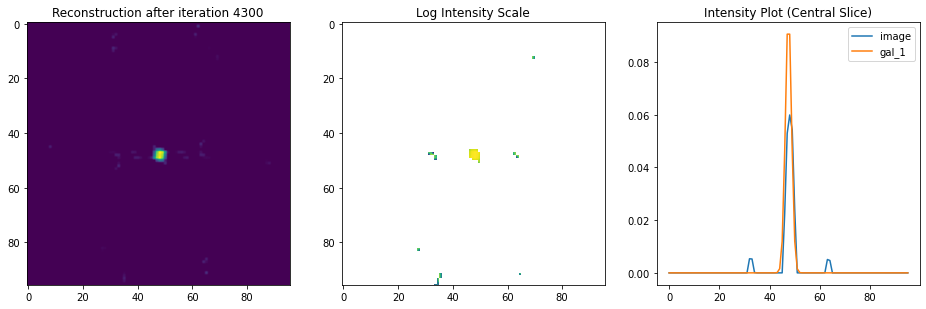

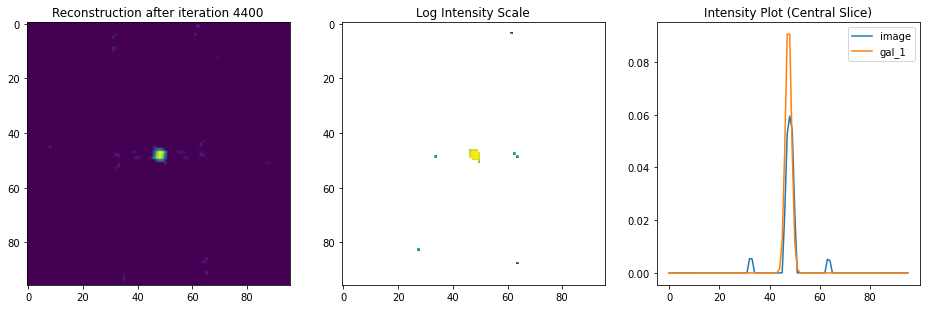

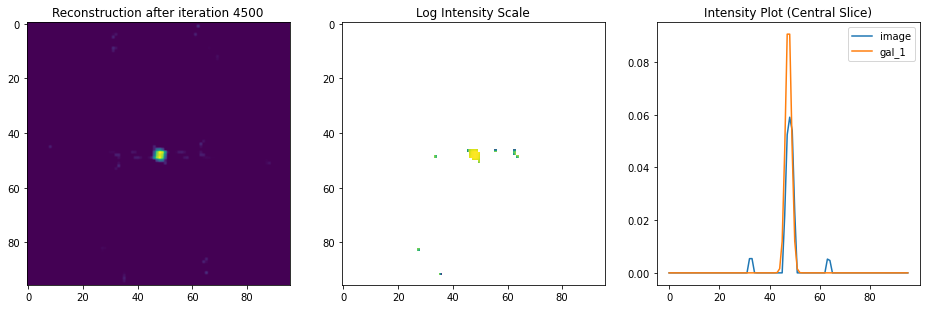

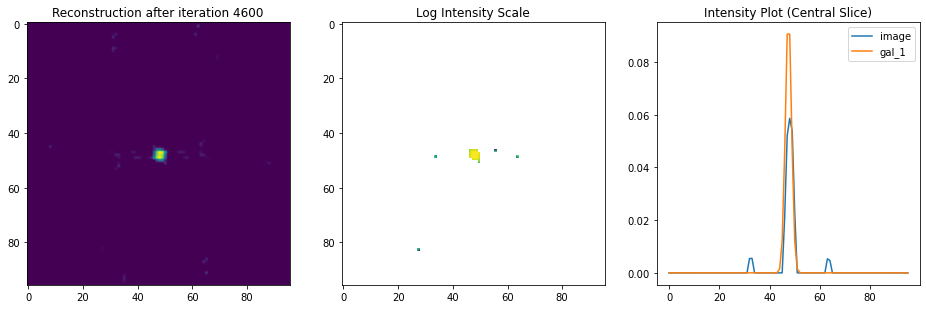

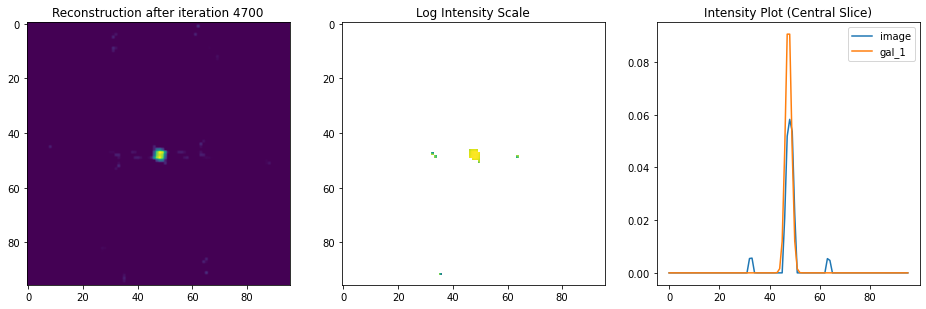

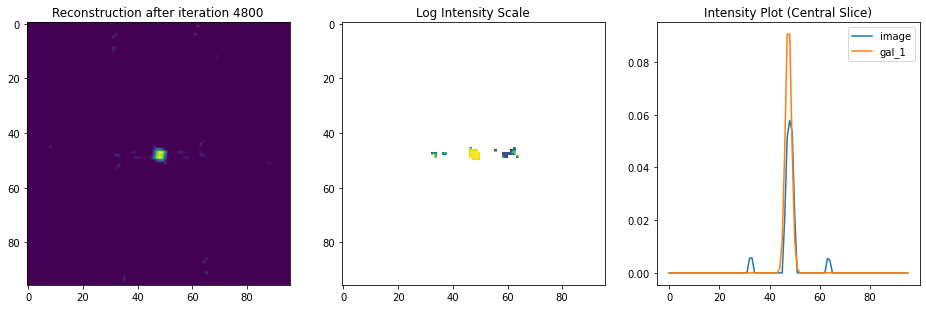

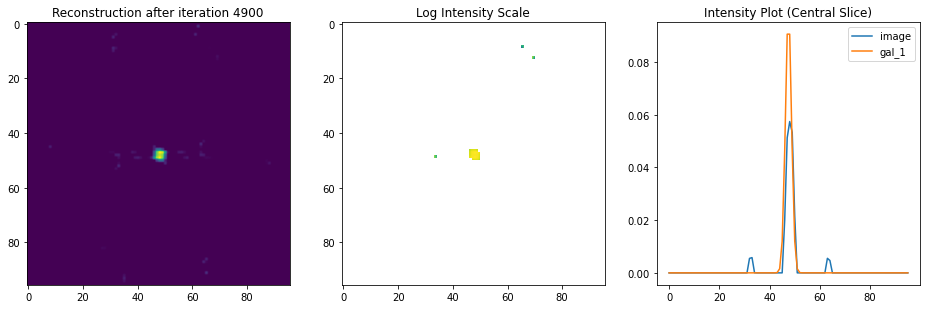

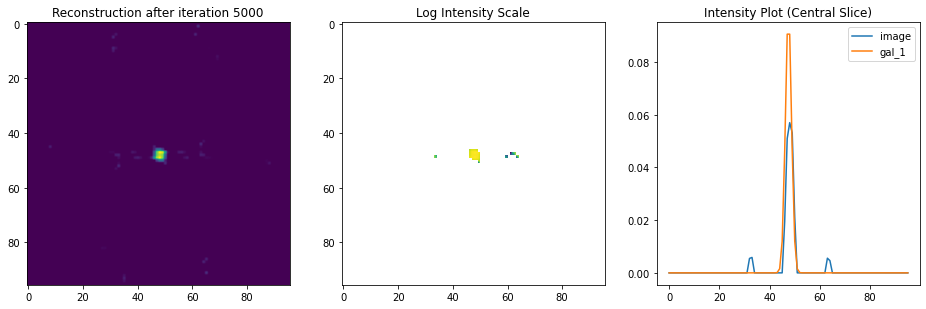

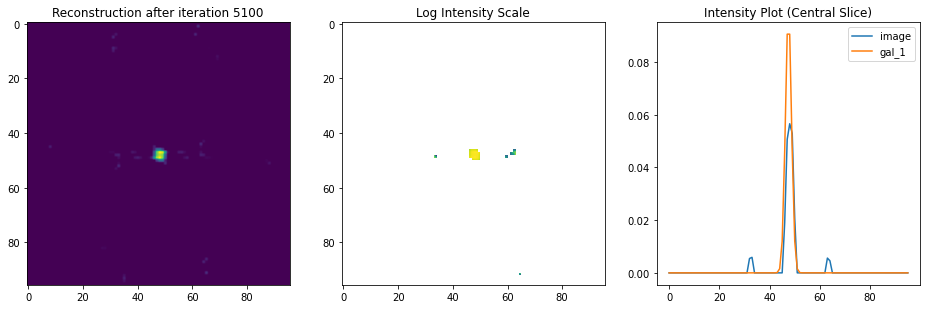

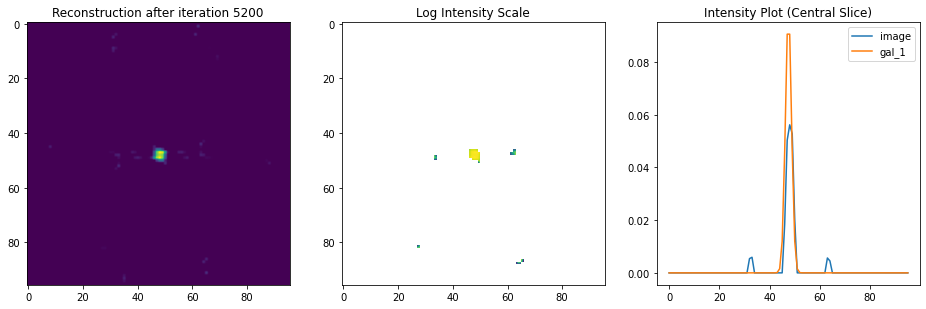

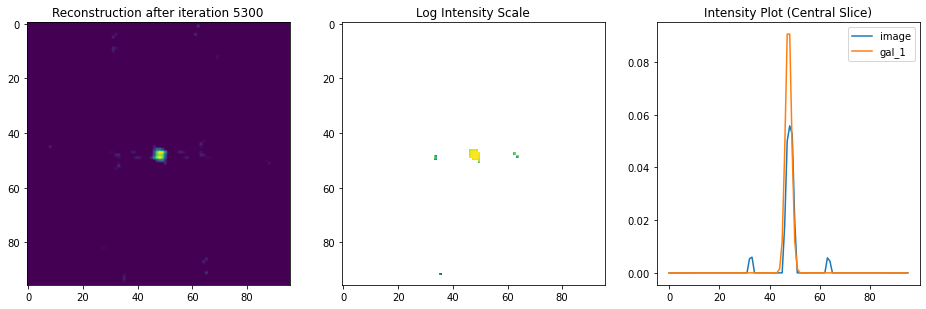

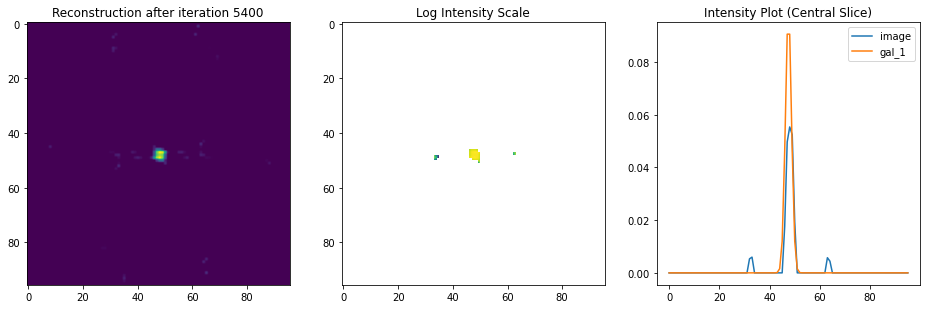

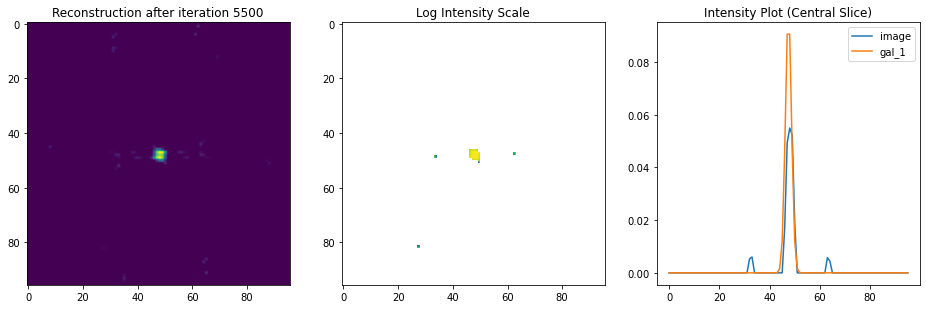

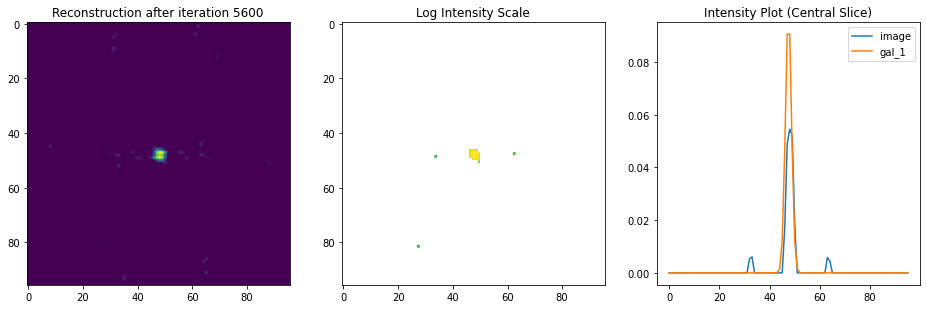

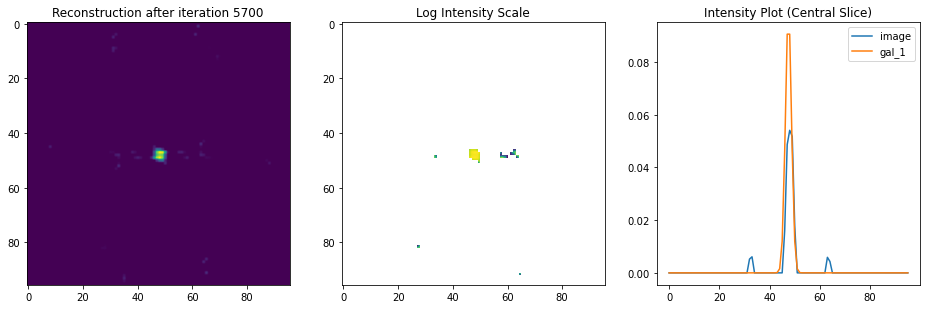

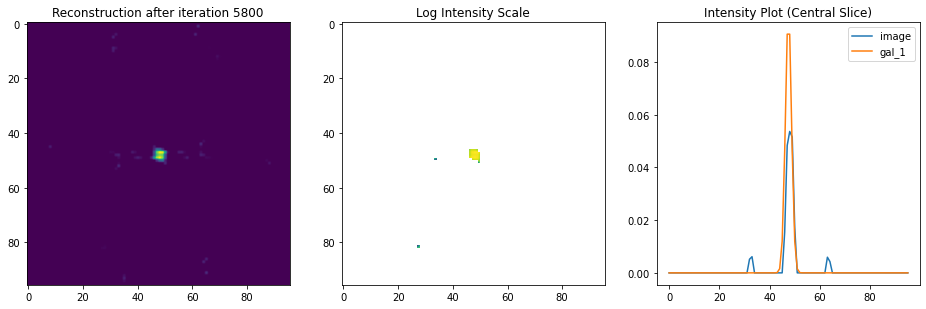

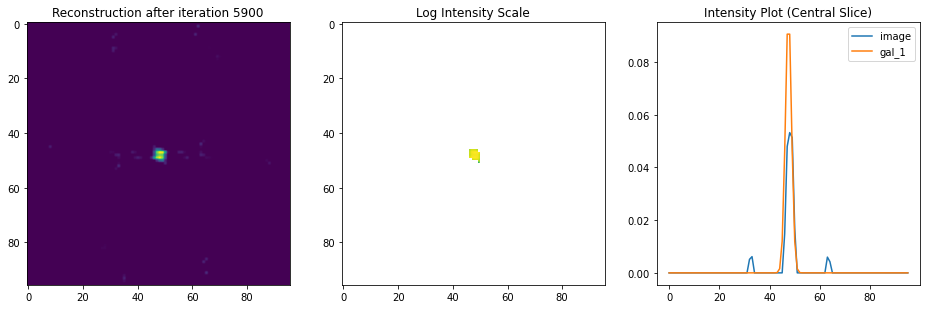

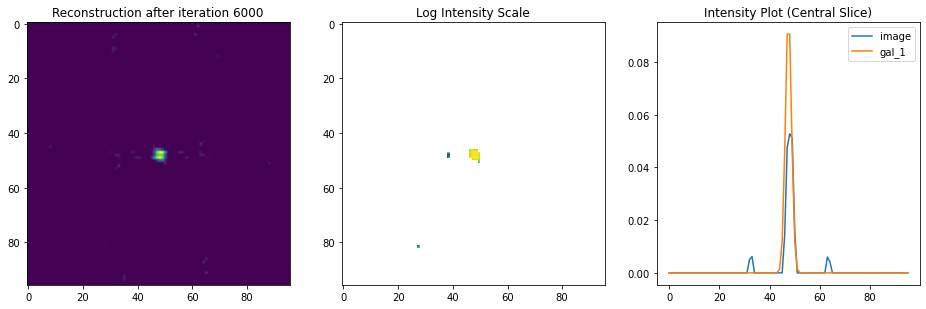

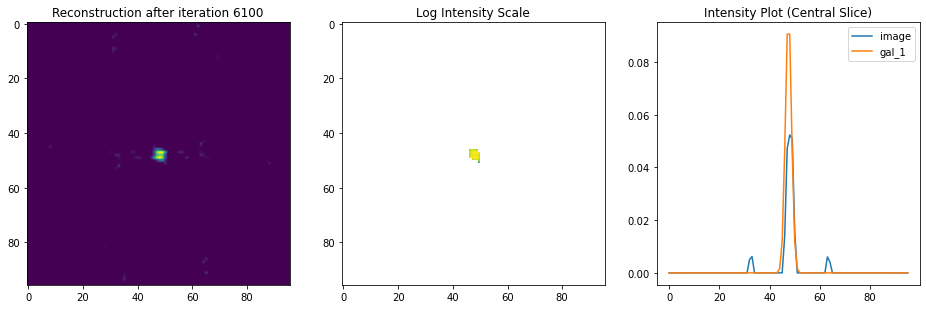

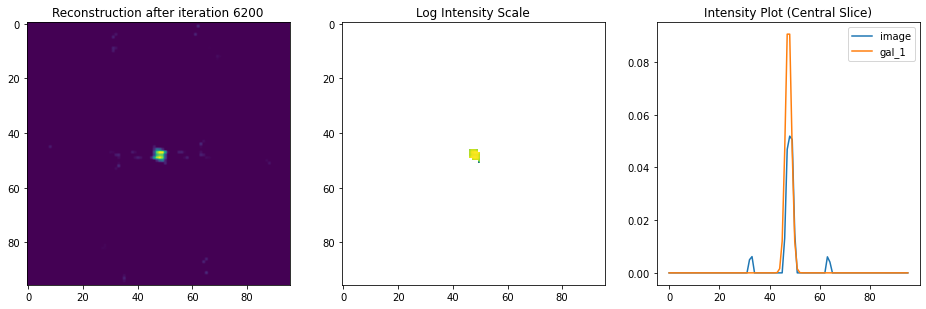

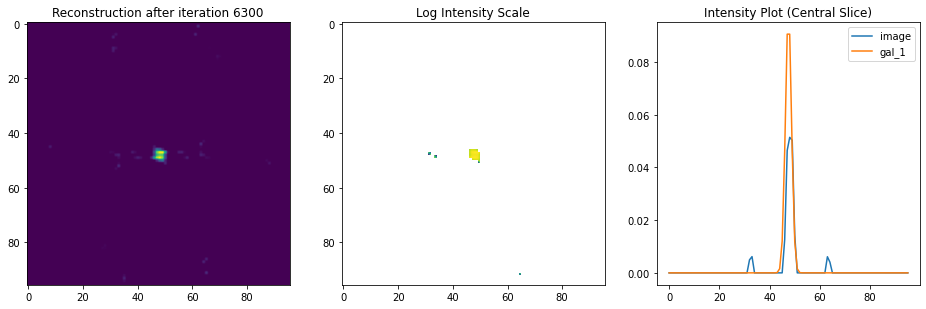

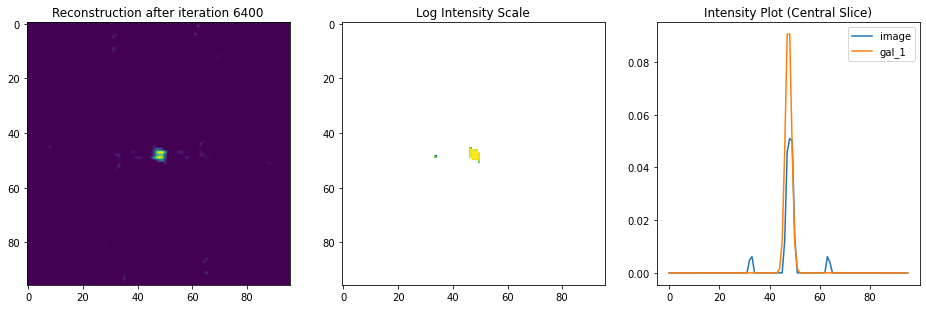

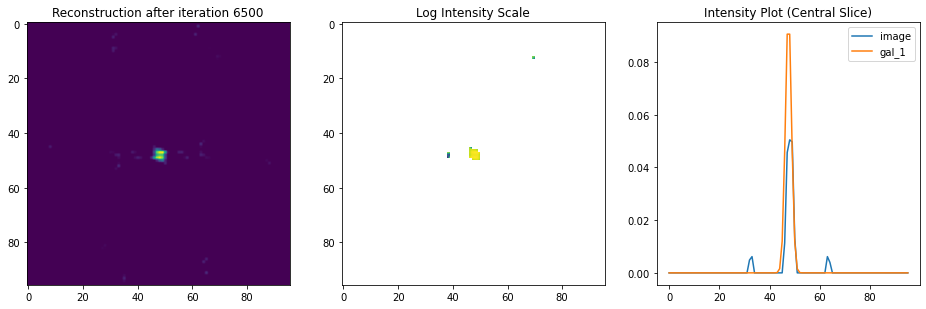

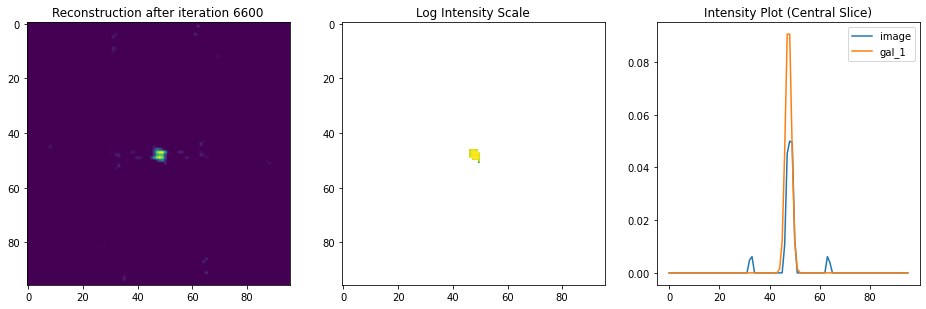

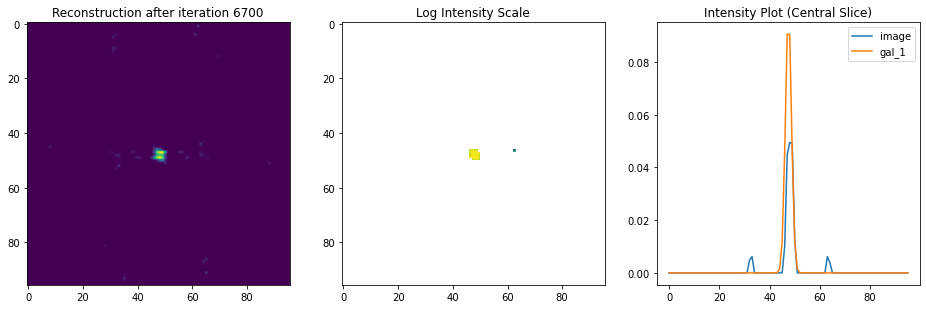

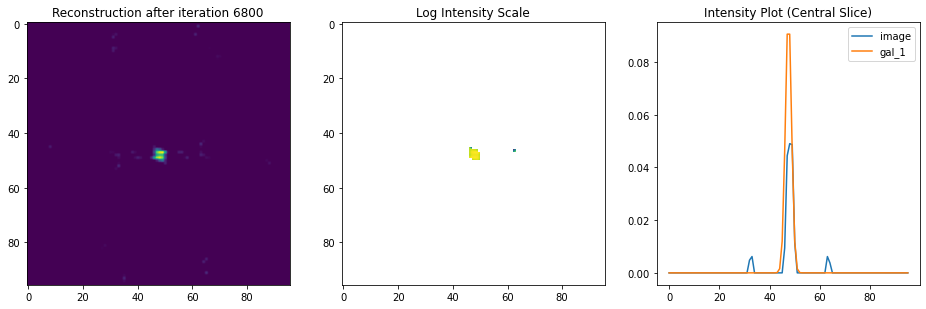

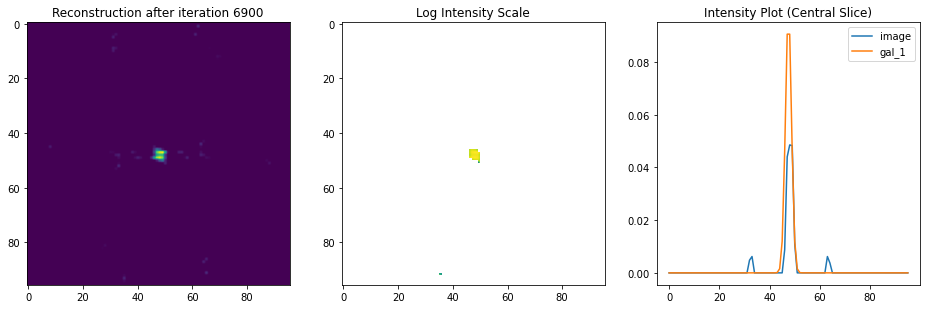

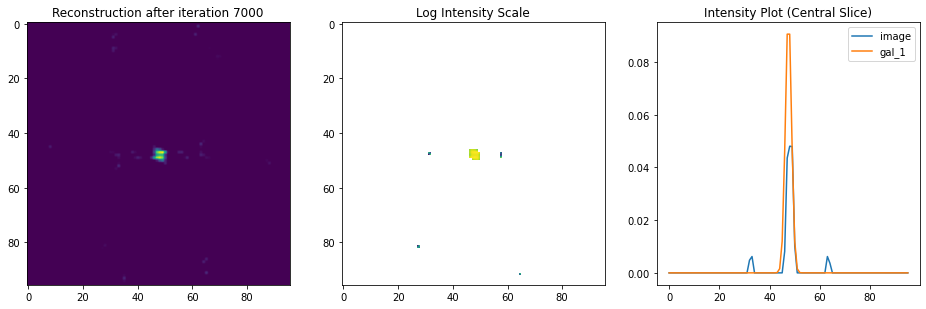

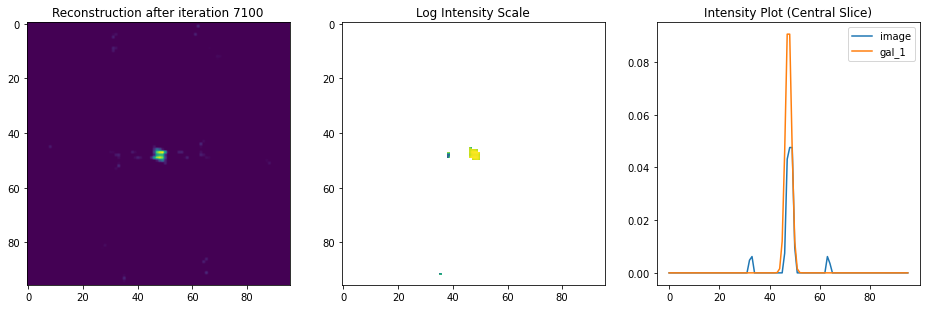

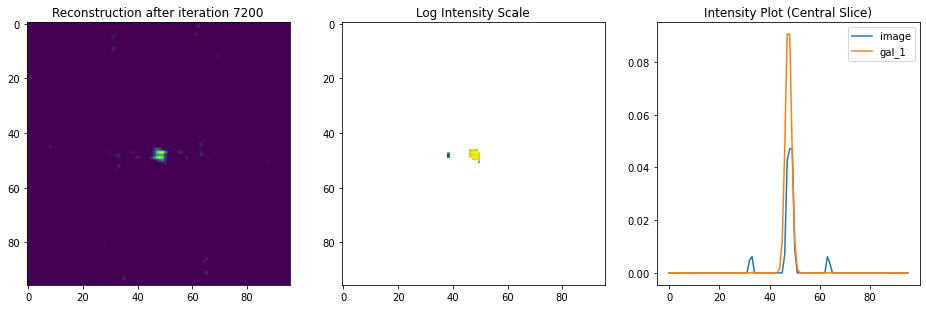

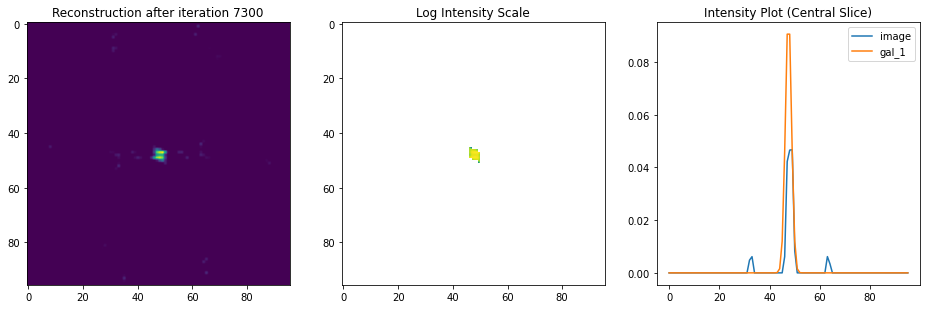

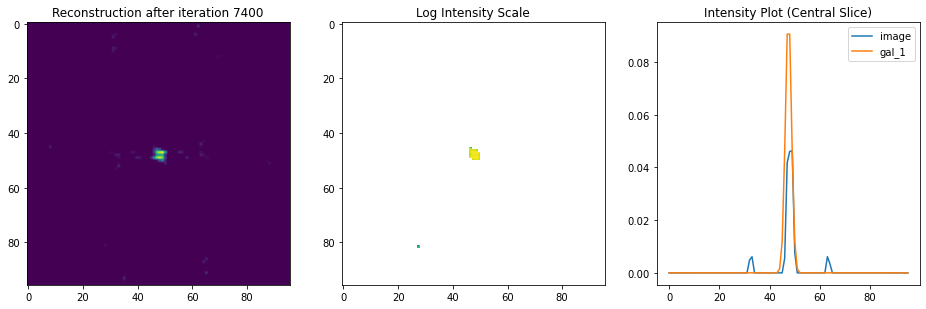

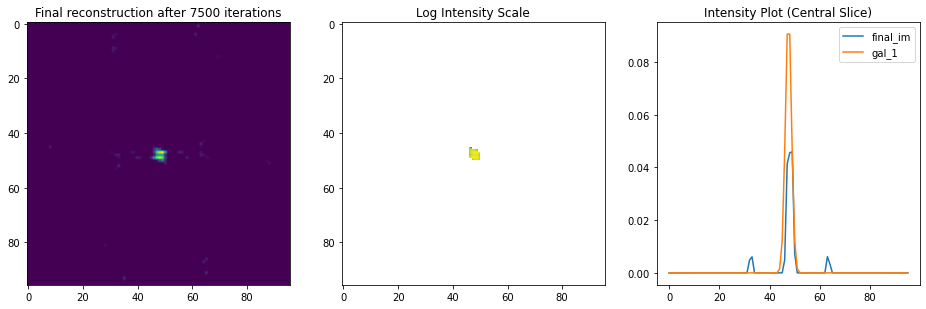

In [14]:
final_im, x_opt, nmse_arr = grad_descent(psf_img1, final_gal)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,16))
ax1.imshow(final_im); ax1.set_title('Final reconstruction after {} iterations'.format(iters));
ax2.imshow(np.log10(final_im)); ax2.set_title('Log Intensity Scale');

ax3.plot(final_im[48,:], label='final_im');
ax3.plot(gal_1[48,:], label='gal_1'); 
leg = ax3.legend()
ax3.set_aspect(1.0/ax3.get_data_ratio()); ax3.set_title('Intensity Plot (Central Slice)')

plt.show(fig)

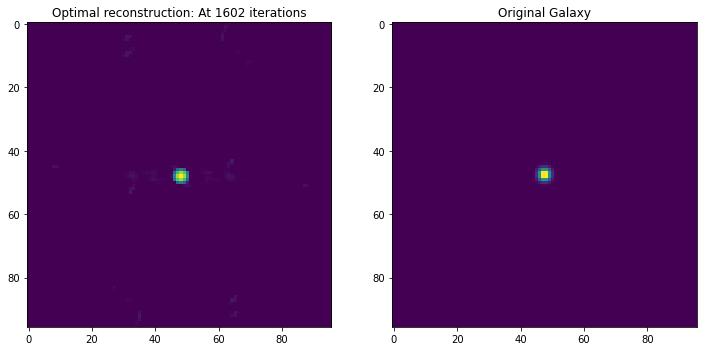

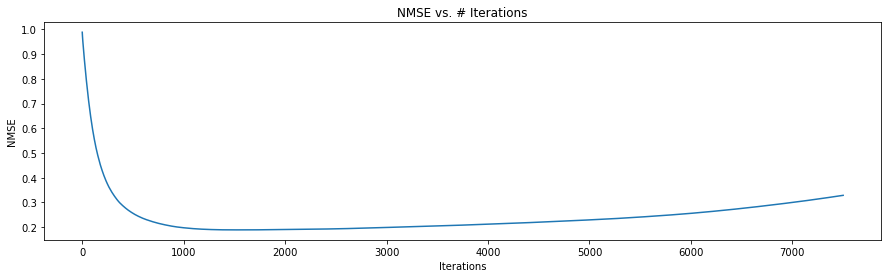


Minimum NMSE at 1602 iterations


In [15]:
# Comparison

min_iter = np.where(nmse_arr == np.min(nmse_arr))[0][0]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))
ax1.imshow(x_opt); ax1.set_title('Optimal reconstruction: At {} iterations'.format(min_iter));
ax2.imshow(gal_1); ax2.set_title('Original Galaxy');
plt.show(fig)

fig2, ax3 = plt.subplots(1,1, figsize=(15,4))
ax3.plot(np.arange(1,iters+1), nmse_arr); ax3.set_title('NMSE vs. # Iterations');
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.show(fig2)
print('\nMinimum NMSE at {} iterations'.format(min_iter))